In [2]:
import sagemaker
from sagemaker.debugger import Rule
from sagemaker.debugger import rule_configs
from sagemaker.session import TrainingInput
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import HyperparameterTuner

___

In [3]:
region = sagemaker.Session().boto_region_name
print(f"AWS Region: {region}")

role = sagemaker.get_execution_role()
print(f"RoleArn: {role}")

sm_sess = sagemaker.session.Session()

AWS Region: eu-west-3
RoleArn: arn:aws:iam::260598086981:role/service-role/AmazonSageMaker-ExecutionRole-20210916T222927


In [4]:
bucket = sagemaker.Session().default_bucket()
bucket

'sagemaker-eu-west-3-260598086981'

In [6]:
prefix = "demo-sagemaker-boston"
model = 'knn'
s3_output_location = f's3://{bucket}/{prefix}/{model}'
print(f"s3 output location: {s3_output_location}")

s3 output location: s3://sagemaker-eu-west-3-260598086981/demo-sagemaker-boston/knn


In [9]:
container=sagemaker.image_uris.retrieve("knn", region)
print(f"Container URI: {container}")

Container URI: 749696950732.dkr.ecr.eu-west-3.amazonaws.com/knn:1


In [20]:
train_input = TrainingInput(
    f"s3://{bucket}/{prefix}/data/train.csv", content_type="text/csv",
)
validation_input = TrainingInput(
    f"s3://{bucket}/{prefix}/data/validation.csv", content_type="text/csv",
)

In [21]:
knn_model = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path=s3_output_location,
    sagemaker_session=sm_sess,
)

In [22]:
knn_model.set_hyperparameters(
    feature_dim= 13,
    sample_size = 303, 
    predictor_type = 'regressor'
)

### Hyperparameter tunning
- https://docs.aws.amazon.com/es_es/sagemaker/latest/dg/kNN-tuning.html

In [26]:
hyperparameter_ranges = {
    "k": IntegerParameter(1, 15, scaling_type="Linear"),
}

In [27]:
tuner = HyperparameterTuner(
    knn_model,
    "test:mse",
    hyperparameter_ranges,
    objective_type='Minimize',
    max_jobs=5,
    max_parallel_jobs=5,
    strategy="Random",
)

In [28]:
tuner.fit(
    {"train": train_input, "test": validation_input},
)

.......................................................!


In [29]:
df= sagemaker.HyperparameterTuningJobAnalytics(
    tuner.latest_tuning_job.job_name
).dataframe()

In [30]:
df

,k,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,11.0,knn-211021-2115-005-5b70b953,Completed,47.412113,2021-10-21 21:18:05+00:00,2021-10-21 21:20:05+00:00,120.0
1,4.0,knn-211021-2115-004-9b35855b,Completed,39.526333,2021-10-21 21:18:37+00:00,2021-10-21 21:20:07+00:00,90.0
2,2.0,knn-211021-2115-003-c928c82b,Completed,35.825966,2021-10-21 21:18:23+00:00,2021-10-21 21:20:12+00:00,109.0
3,7.0,knn-211021-2115-002-cda8e075,Completed,41.193661,2021-10-21 21:17:57+00:00,2021-10-21 21:20:11+00:00,134.0
4,12.0,knn-211021-2115-001-238c9671,Completed,51.230217,2021-10-21 21:18:23+00:00,2021-10-21 21:20:03+00:00,100.0


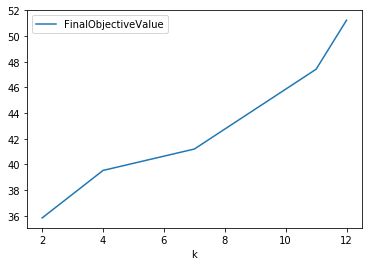

In [32]:
df.loc[
    :, ['FinalObjectiveValue', 'k']
].set_index('k').sort_index().plot()